In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
 
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Solving problem 
$$
\begin{array}{ll}
\text{minimize} & q(z) + h(x) \\
\text{subject to} & x = Az
\end{array}
$$

### Special case
$$
\begin{array}{ll}
\text{minimize} & g^\top z  \\
\text{subject to} & \|Az\|_{\max} \leq \beta 
\end{array}
$$
where $g \in \mathcal{R}(A^\top)$

## PDHG 
$$
\begin{aligned}
y^{t+1} &= \operatorname{prox}_{\rho h^*}\!\bigl(y^t + \rho\, A(2 z^t - z^{t-1})\bigr), \\
z^{t+1} &= \operatorname{prox}_{\gamma q}\!\bigl(z^t - \gamma A^\top y^{t+1}\bigr).
\end{aligned}
$$

Residuals
$$
\begin{aligned}
r_1^{t+1} &= \frac{1}{\rho}\left (y^{t+1} - y^t - \rho A(2z^t - z^{t-1} - z^{t+1})\right ) \\
r_2^{t+1} &= \frac{1}{\gamma} \left (z^{t+1} - z^t \right)
\end{aligned}
$$
The stopping cirterion is
$$
\begin{aligned}
 \|r_1^{t+1}\|_2 &\leq \sqrt{m} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|Az^{t+1}\|_2\\
 \|r_2^{t+1}\|_2 &\leq \sqrt{n} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|A^\top y^{t+1}\|_2.
\end{aligned}
$$


In [3]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
np.random.seed(0)
for (m, n) in [(50, 100), (100, 50)]:
    for _ in range(5):
        A_np = np.random.randn(m, n)
        G1_np = A_np.T @ np.random.randn(m, 1)
        beta = 1
        z0, y0, f_star = cvxpy_A(G1_np, A_np, beta) 
 
        # Torch tensors
        A1 = torch.from_numpy(A_np).to(torch.float32).to(device).t()
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device) 

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z1_t, __annotations__, residuals, _ = pdhg_method_AB(
            prox_h_conj,
            A2=None,
            A1=A1,
            G1=G1,
            G2=None,
            max_iter=10000,
            eps_abs=1e-8,
            eps_rel=1e-8,
            stopping=False,
            f_star=f_star,
            h_conj=h_conj, 
            beta=beta
        )

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy() 

        assert np.allclose(z0.T @ G1_np, Z1.T @ G1_np, atol=1e-3, rtol=1e-3), print(z0.T @ G1_np, Z1.T @ G1_np)
        assert np.linalg.norm(A_np @ Z1, np.inf) <= beta + 1e-2 and np.linalg.norm(A_np @ z0, np.inf) <= beta + 1e-2
        print("PASSED")

lamb_max=69.6816177368164
PASSED
lamb_max=69.87359619140625
PASSED
lamb_max=70.407470703125
PASSED
lamb_max=70.07579803466797
PASSED
lamb_max=70.307373046875
PASSED
lamb_max=70.96698760986328
PASSED
lamb_max=71.32703399658203
PASSED
lamb_max=70.76106262207031
PASSED
lamb_max=70.61338806152344
PASSED
lamb_max=70.82266235351562
PASSED


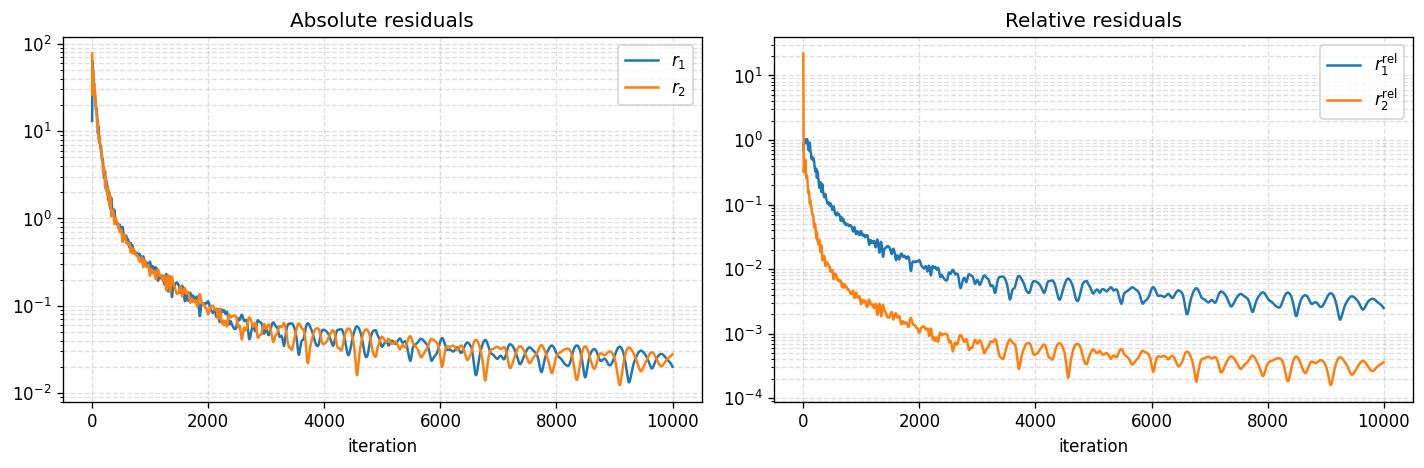

In [5]:
plot_residuals(residuals)

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )
\end{aligned}
$$


In [ ]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5
        Z0_1, Z0_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta)

        # Torch tensors
        A2 = torch.from_numpy(A_np).to(torch.float32).to(device)
        A1 = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z1_t, Z2_t, residuals, _ = pdhg_method_AB(
            prox_h_conj,
            A2=A2,
            A1=A1,
            G1=G1,
            G2=G2,
            max_iter=10000,
            eps_abs=1e-8,
            eps_rel=1e-8,
            stopping=False,
            h_conj=h_conj,
            f_star=f_star,
            beta=beta,
        )

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
        print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


lamb_max=60.042948911588766
PASSED
lamb_max=59.7796818648767
PASSED
lamb_max=60.78409843290087
PASSED
lamb_max=59.37420393691023
PASSED
lamb_max=60.361789696788186
PASSED
lamb_max=60.081391637671295
PASSED
lamb_max=60.04998184496628
PASSED
lamb_max=59.64461369023844
PASSED
lamb_max=59.72348211615672
PASSED
lamb_max=60.91859389058868
PASSED


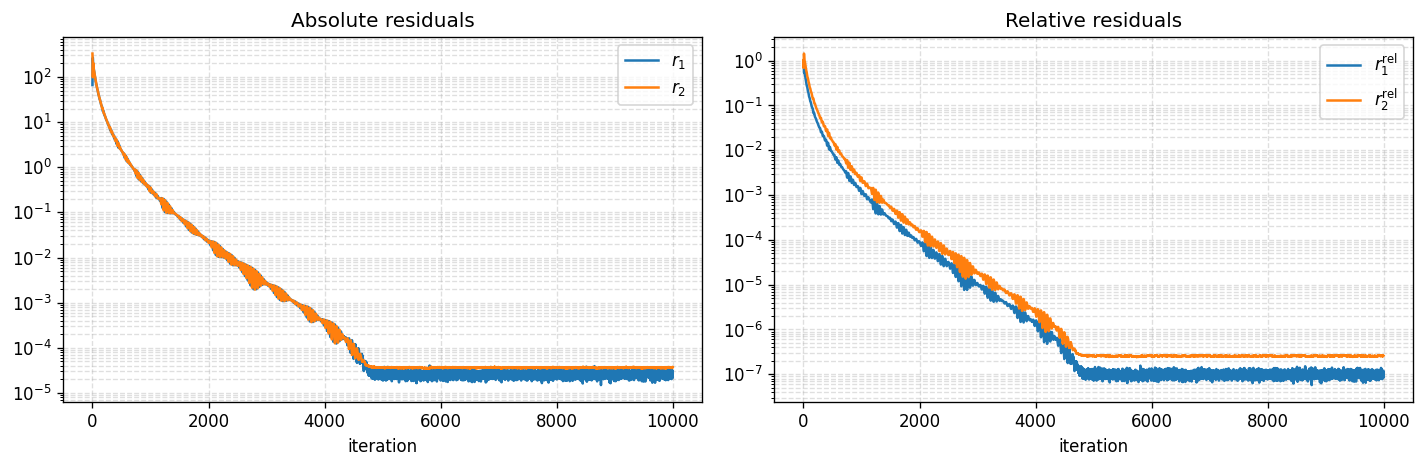

In [6]:
plot_residuals(residuals)

## Dual feasibility checks

In [7]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(5):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = check_dual_feasible(A, B, G1, G2, max_kron=10)
        _, res2 = check_dual_feasible(A.to(torch.float32), B.to(torch.float32), G1.to(torch.float32), G2.to(torch.float32), max_kron=10)
        print("residual:", res1, "residual (float32):", res2)

30x60
residual: 1.4475150904480759e-11 residual (float32): 3.295595014665622
residual: 1.309174870409728e-11 residual (float32): 0.0049029121895227306
residual: 1.3383547094872188e-11 residual (float32): 0.11473790554343408
residual: 1.3540950634967938e-11 residual (float32): 4.897411288990943
residual: 1.3115379797555143e-11 residual (float32): 0.1902154313650987
60x30
residual: 1.1234489012302786e-11 residual (float32): 2.2916004378159957e-08
residual: 8.715907464059474e-12 residual (float32): 2.3512540763126548e-08
residual: 7.152909668839678e-12 residual (float32): 2.3839035032892477e-08
residual: 7.738427775819138e-12 residual (float32): 2.3826798135145103e-08
residual: 8.035027036445527e-12 residual (float32): 2.2828519324295796e-08
60x60
residual: 2.766738468555258e-11 residual (float32): 5.963636470422261e-08
residual: 3.108799502792059e-11 residual (float32): 6.249568819675125e-08
residual: 2.2282447460202396e-11 residual (float32): 6.581490276276534e-08
residual: 2.3702319453

In [8]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A = torch.from_numpy(A_np).to(torch.float32).to(device)
    B = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    Y0, dual_res = check_dual_feasible(A, B, G1, G2)
    print(f"{dual_res=}")

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z1_t, Z2_t, residuals, _ = pdhg_method_AB(
        prox_h_conj,
        W_k=A,
        W_q=B,
        G_wk=G1,
        G_wq=G2,
        max_iter=50000,
        eps_abs=1e-8,
        eps_rel=1e-8,
        stopping=False,
        Y0=Y0,
        h_conj=h_conj,
        beta=beta
    )

    # Back to NumPy for comparison
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()


dual_res=1.4296215844762104e-07
lamb_max=707.1898927384864


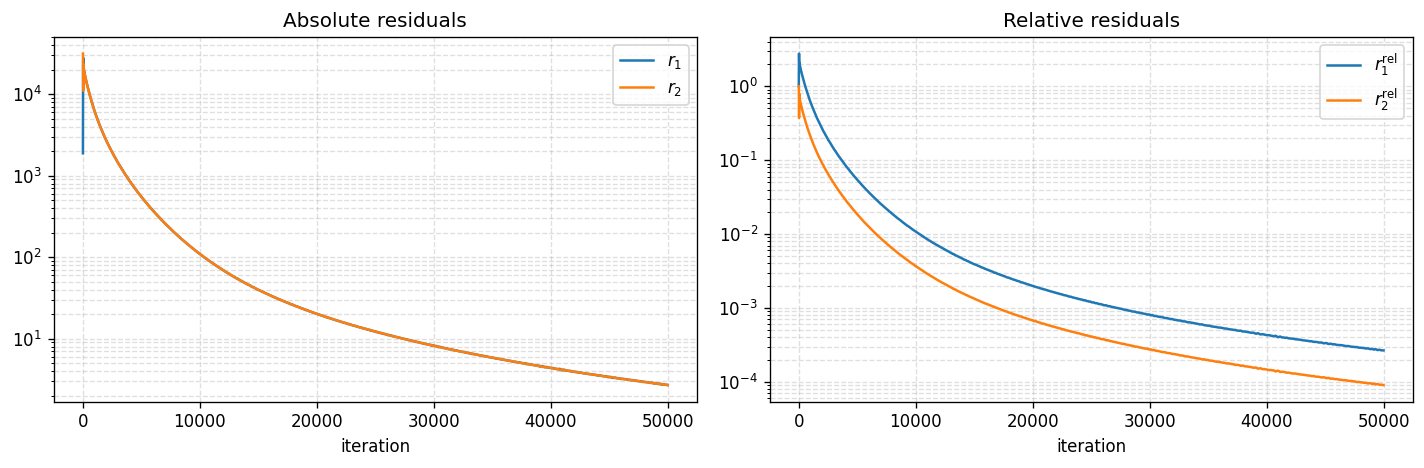

In [9]:
plot_residuals(residuals)

In [15]:
max(residuals["r1_rel"][:50]), max(residuals["r2_rel"][:50]), min(residuals["r1_rel"][:50]), min(residuals["r2_rel"][:50])

(2.7664867600825516, 1.0, 1.0, 0.37219327075318764)